In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import os
import numpy as np
from utils_eval import extract_metrics
import torch
from tensor_builder import getDataSet
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix



In [2]:
def single_plot(data, best_f1_cf, best_loss_cf, epochs_up_to=None):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    if epochs_up_to == None:
        epochs_up_to = len(data['train_loss'])

    axs[0, 0].plot(data['train_loss'][:epochs_up_to], label='Train Loss')
    axs[0, 0].plot(data['dev_loss'][:epochs_up_to], label='Validation Loss')
    axs[0, 0].set_title('Loss vs Epochs')
    axs[0, 0].legend()
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].axhline(data["best_loss_dev"], color='g', linestyle='--', label=f'Best Dev Loss: {data["best_loss_dev"]:.3f}')
    axs[0, 0].legend()

    axs[0, 1].plot(data['train_f1'][:epochs_up_to], label='Train F1')
    axs[0, 1].plot(data['dev_f1'][:epochs_up_to], label='Validation F1')
    axs[0, 1].set_title('F1 Score vs Epochs')
    axs[0, 1].legend()
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('F1')
    axs[0, 1].axhline(data["best_f1_dev"], color='g', linestyle='--', label=f'Best Dev F1: {data["best_f1_dev"]:.3f}')
    axs[0, 1].legend()

    cf_f1 = np.array(best_f1_cf)
    ConfusionMatrixDisplay(cf_f1).plot(ax=axs[1, 1])
    axs[1, 1].set_title('Confusion Matrix for Best F1 Model')


    cf_loss = np.array(best_loss_cf)
    ConfusionMatrixDisplay(cf_loss).plot(ax=axs[1,0])
    axs[1,0].set_title('Confusion Matrix for Best Loss Model')

    plt.tight_layout()
    plt.show()

    # return fig

In [3]:
def get_cf(model_path, batch_size=-1, random_state=69, window_size=300, stride=50, norm='true'):
    model = torch.load(model_path)
    model.eval()
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)
    
    _, test_dataset = getDataSet(randomState=random_state, window_size=window_size, stride=stride, flatten=False)
    if batch_size == -1:
        batch_size = len(test_dataset)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).squeeze()
            
            outputs = model(X_batch)
            predictions = (torch.sigmoid(outputs) > 0.5).long().flatten()
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    conf_matrix = confusion_matrix(all_labels, all_preds, normalize=norm)
    return conf_matrix

In [4]:
def read_txt(dir):
    txt_path = os.path.join(dir, f'desc.txt')
    with open(txt_path, 'r') as f:
        content = f.read()
    dic = eval(content)
    return dic['window_size'], dic['stride'] 


In [5]:
def main(eval_dir_path, norm, epochs_up_to):
    head_tail = os.path.split(eval_dir_path)
    metrics = extract_metrics(basedir=head_tail[0], subdir=head_tail[1])
    best_f1_model_path = os.path.join(eval_dir_path, f'{head_tail[1]}_bestLoss.pth')
    best_loss_model_path = os.path.join(eval_dir_path, f'{head_tail[1]}_bestF1.pth')
    window_size, stride = read_txt(eval_dir_path) #get the specific stride and widow size used for this model

    best_f1_cf = get_cf(best_f1_model_path, window_size=window_size, stride=stride, norm=norm)
    best_loss_cf = get_cf(best_loss_model_path, window_size=window_size, stride=stride, norm=norm)
    single_plot(data=metrics, best_f1_cf=best_f1_cf, best_loss_cf=best_loss_cf, epochs_up_to=epochs_up_to) 


Using device: cuda:1
Using device: cuda:1


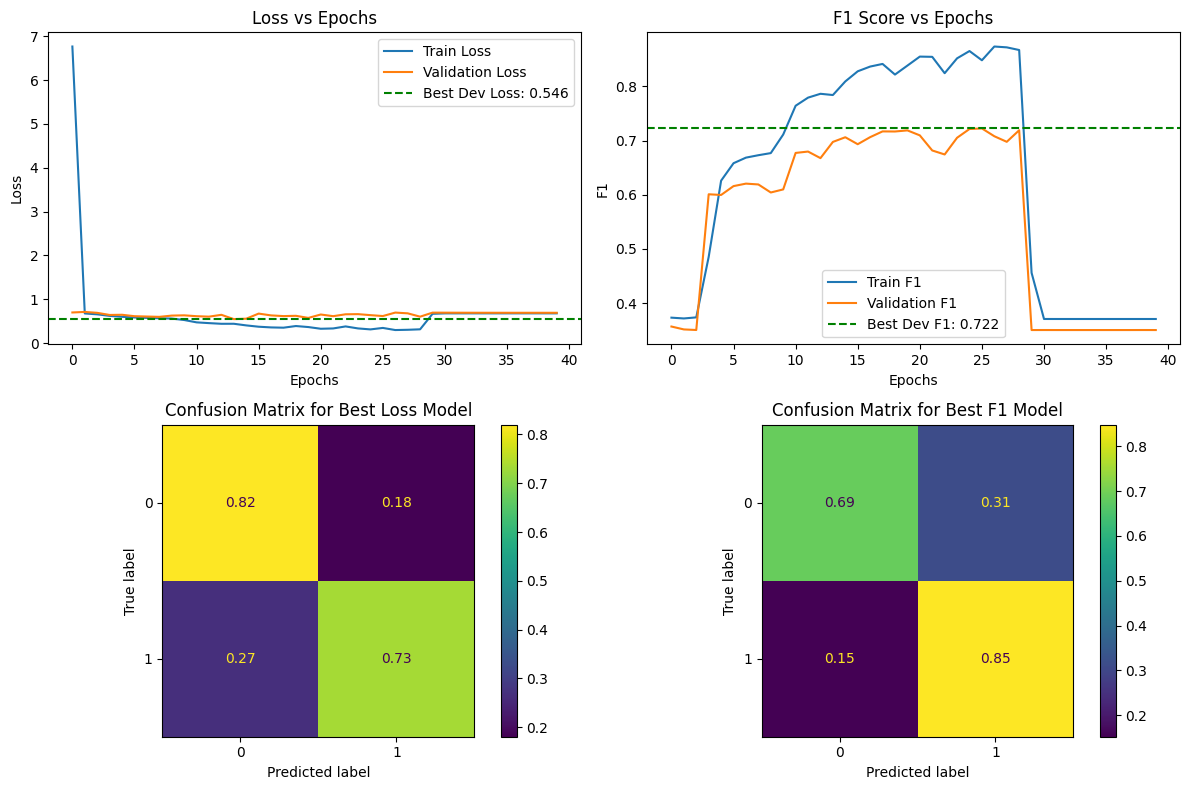

In [6]:
eval_dir_path = '/home/kuba/Projects/MedicationTakingData/resmodel/res_search_00/res_search_00_7'
cf_norm_on = 'true' # 'pred  
epochs_up_to = 40

main(eval_dir_path, cf_norm_on, epochs_up_to)

